# Real-Time Concrete Crack Detection and Classification using Transfer Learning CNN with Masking Techniques
### Members: 
* Anacio, Jemuel O.
* Capinpin, Marc Kristofer A.
* Gonzales, Krizelle Mae B.


Dataset: https://www.kaggle.com/datasets/arnavr10880/concrete-crack-images-for-classification/data

## 1. Import Dependencies

In [22]:
import os
import shutil
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

## 2. Data Pre-Processing
    2.0 Data Exploration
    2.1 Data Splitting
    2.2 Data Augmentation
    2.3 Data Loading Function

### 2.0 Data Exploration

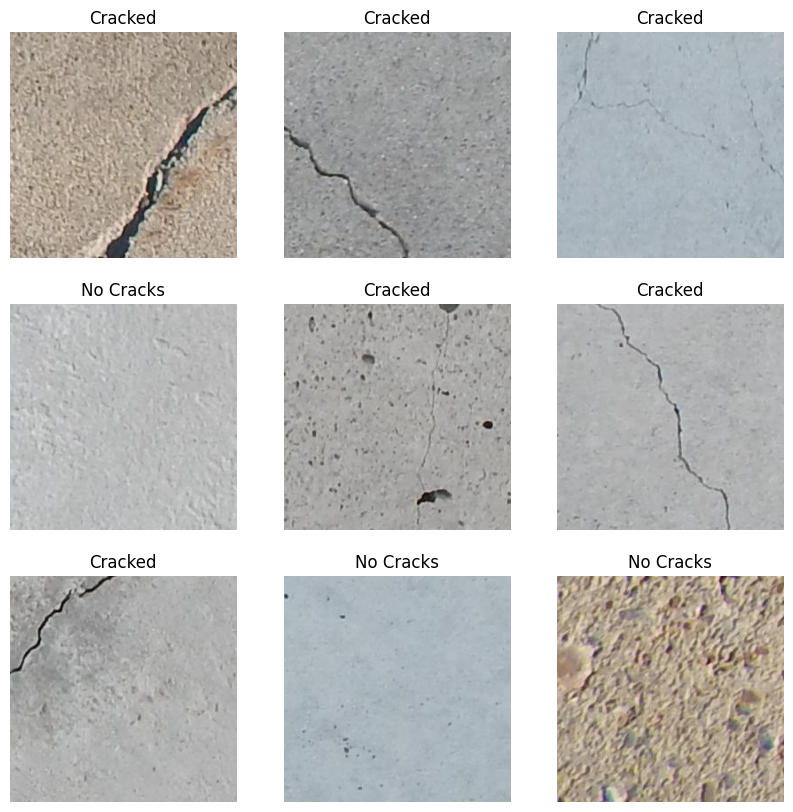

Number of cracked samples: 8484
Number of no cracks samples: 47608


In [4]:
data_path = 'data/Dataset (Focal)'

num_samples = 9

classes = ['Cracked', 'No Cracks']

# Display `num_samples` random samples from the dataset
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
for i in range(num_samples):
    class_name = random.choice(classes)

    # Load the image
    img_path = os.path.join(data_path, f'{class_name}/{random.choice(os.listdir(os.path.join(data_path, class_name)))}')
    img = mpimg.imread(img_path)

    # Display the image
    axs[i//3, i%3].imshow(img)
    axs[i//3, i%3].axis('off')
    axs[i//3, i%3].set_title(class_name)

plt.show()

# Display the number of samples in the dataset
num_positive_samples = len(os.listdir(os.path.join(data_path, 'Cracked')))
num_negative_samples = len(os.listdir(os.path.join(data_path, 'No Cracks')))
print('Number of cracked samples:', num_positive_samples)
print('Number of no cracks samples:', num_negative_samples)

### 2.1 Data Splitting

In [5]:
import splitfolders
splitfolders.ratio('data/dataset', output="data/split_data", seed=1337, ratio=(0.7, 0.1, 0.2)) 

In [6]:
# Sampling 5000 each class from the Focal Paper's dataset
src_dir = 'data/dataset (focal)'
dst_dir = 'data/sample_data (focal)'

class_names = ['cracked', 'no cracks']
for class_name in class_names:
    dst_class_dir = os.path.join(dst_dir, class_name)
    os.makedirs(dst_class_dir, exist_ok=True)

num_images = 5000

for class_name in class_names:
    src_class_dir = os.path.join(src_dir, class_name)
    dst_class_dir = os.path.join(dst_dir, class_name)
    files = os.listdir(src_class_dir)
    files = sorted(files)

    for i, filename in enumerate(files):
        if i >= num_images:
            break

        src_file = os.path.join(src_class_dir, filename)
        dst_file = os.path.join(dst_class_dir, filename)

        shutil.copy(src_file, dst_file)

In [7]:
# Splitting the data new sample data from focal paper's dataset
splitfolders.ratio('data/sample_data (focal)', output="data/split_data", seed=1337, ratio=(0.7, 0.1, 0.2)) 

### 2.2 Data Augmentation

In [8]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
])

### 2.3 Data Loading Function

In [13]:
batch_size = 32
img_size = (224, 224)

# Define the data loaders for training and test sets
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    'data/split_data/train',
    image_size=img_size,
    batch_size=batch_size,
    label_mode='binary')

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    'data/split_data/test',
    image_size=img_size,
    batch_size=batch_size,
    label_mode='binary')

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    'data/split_data/val',
    image_size=img_size,
    batch_size=batch_size,
    label_mode='binary')

Found 35000 files belonging to 2 classes.
Found 10000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [8]:
print(train_data.class_names)

['cracked', 'no cracks']


In [9]:
# Rescale the pixel values to be between 0 and 1
train_data = train_data.map(lambda x, y: (x / 255., y))
test_data = test_data.map(lambda x, y: (x / 255., y))
val_data = val_data.map(lambda x, y: (x / 255., y))

# Shuffle and prefetch the data for better performance
train_data = train_data.shuffle(buffer_size=1000)
train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_data.prefetch(buffer_size=tf.data.AUTOTUNE)

### Data Generators

In [14]:
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

## Building the model

In [19]:
from keras.applications import EfficientNetB0
from keras.layers import Flatten, Dense
from keras.models import Model

# Load the pre-trained EfficientNetB0 model with input shape
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze the top 10 layers of the base model
for layer in base_model.layers[-10:]:
    layer.trainable = True


# Add custom layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)


optimizer = Adam(learning_rate=0.0001)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [20]:
model.fit(train_data, epochs=10, validation_data=val_data, callbacks=[early_stopping])

Epoch 1/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 3607s 3s/step - accuracy: 0.9589 - loss: 0.1312 - val_accuracy: 0.9838 - val_loss: 0.0438
Epoch 2/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 3535s 3s/step - accuracy: 0.9911 - loss: 0.0256 - val_accuracy: 0.9858 - val_loss: 0.0423
Epoch 3/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 3529s 3s/step - accuracy: 0.9951 - loss: 0.0139 - val_accuracy: 0.9866 - val_loss: 0.0487
Epoch 4/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 3639s 3s/step - accuracy: 0.9958 - loss: 0.0129 - val_accuracy: 0.9888 - val_loss: 0.0585
Epoch 5/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 3402s 3s/step - accuracy: 0.9955 - loss: 0.0159 - val_accuracy: 0.9884 - val_loss: 0.0404
Epoch 6/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 3505s 3s/step - accuracy: 0.9970 - loss: 0.0098 - val_accuracy: 0.9888 - val_loss: 0.0524
Epoch 7/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 3643s 3s/step - accuracy: 0.9972 - loss: 0.0089 - val_accuracy: 0.9870 - val_loss: 0.0575
Epoch 8/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 3809s 3s/step - accuracy: 0.9975 -

In [24]:
model.save('model.h5')

## Testing the Model

In [28]:
model = load_model('model.h5')

# Assuming you have a test data generator 'test_data'
test_data_dir = 'data/split_data/test'

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_data)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 189s 554ms/step - accuracy: 0.9907 - loss: 0.0532
Test Loss: 0.04567757993936539
Test Accuracy: 0.9908999800682068


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


C:\Users\jemue\AppData\Local\Temp\ipykernel_11564\662311206.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_label = class_labels[int(predictions[i] > 0.5)]  # Assuming threshold of 0.5 for binary classification


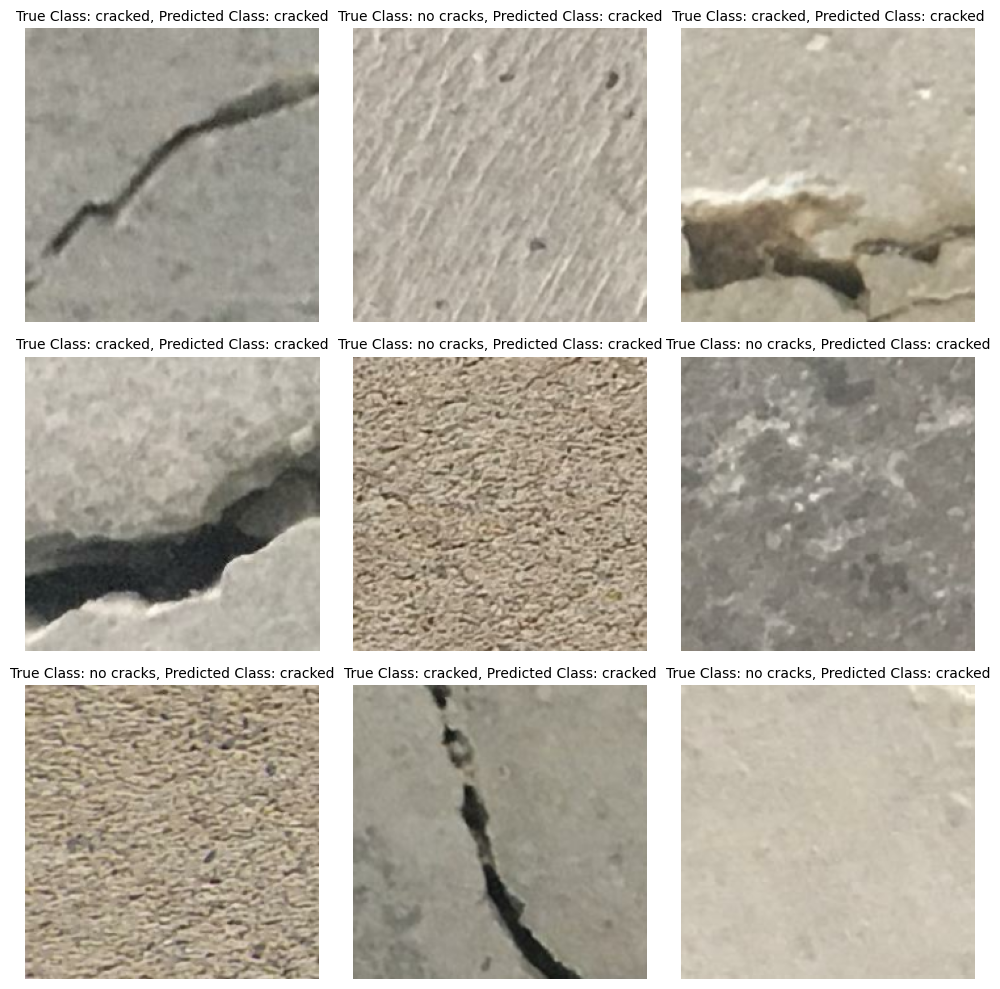

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of images and their true labels from the test data dataset
batch_images, batch_labels = next(iter(test_data))

# Normalize the pixel values to be between 0 and 1
batch_images = batch_images / 255.0

# Make predictions on the batch of images
predictions = model.predict(batch_images)

# Set up a 3x3 grid of subplots
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

# Iterate over the batch to display images and predicted classes
for i in range(9):
    image = batch_images[i]
    true_label = class_labels[int(batch_labels[i])]
    predicted_label = class_labels[int(predictions[i] > 0.5)]  # Assuming threshold of 0.5 for binary classification

    # Display the image on the current subplot
    ax = axs[i // 3, i % 3]
    ax.imshow(image)
    ax.axis('off')

    # Add a title to the subplot
    title = f'True Class: {true_label}, Predicted Class: {predicted_label}'
    ax.set_title(title, fontsize=10)

# Adjust the spacing between the subplots
fig.tight_layout()

# Display the plot
plt.show()
    

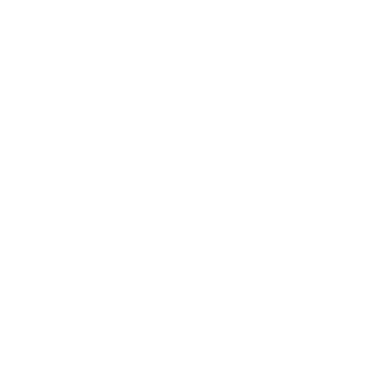

In [38]:
# Get a batch of images and labels from the test data dataset

batch_images, batch_labels = next(iter(test_data))


# Display a single image from the batch

plt.imshow(batch_images[0])

plt.axis('off')

plt.show()

In [ ]:
# from keras.applications import EfficientNetB0
# from keras.layers import Flatten, Dense
# from keras.models import Model

# # Load the pre-trained EfficientNetB0 model with input shape
# base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# # Freeze the layers of the base model
# for layer in base_model.layers:
#     layer.trainable = False


# # Add custom layers on top of the base model
# x = base_model.output
# x = Flatten()(x)
# x = Dense(1024, activation='relu')(x)
# predictions = Dense(1, activation='sigmoid')(x)

# # Create the final model
# model = Model(inputs=base_model.input, outputs=predictions)

# # Compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])